In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pymc3 as pm
import theano

# Linear Regression
Lets generate some data with known slope and intercept and fit a simple linear GLM.

In [2]:
size = 50
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, size)
y = true_intercept + x*true_slope + np.random.normal(scale=.5, size=size)
data = {'x': x, 'y': y}

we know in linear regression errors are normally distributed around the centre zero mean, and its standard deviation a positive real number.

Also we have a prior knowledge that slope and intercept are any real number. Seems like a good candidate for normal distribution (keeping standard deviation very large, i.e. we do not know their true mean in prior).

In [3]:
#defining prior
with pm.Model() as model:
    intercept = pm.Normal("intercept", 0, 100)
    slope = pm.Normal("slope", 0, 100)
    σ = pm.HalfCauchy("σ", 1, transform=None)

In [4]:
print(model.basic_RVs)
print(model.free_RVs)

[intercept, slope, σ]
[intercept, slope, σ]


In [5]:
#defining observed rv or likelihood function
with model:
    error = y - intercept - slope*x
    pm.Normal("error", 0, σ, observed=error)

In [6]:
print(model.basic_RVs)
print(model.observed_RVs)

[intercept, slope, σ, error]
[error]


In [7]:
with model:
    trace = pm.sample(draws=2000, tune=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, slope, intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [05:15<00:00, 19.02draws/s]


In [8]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,1.124,0.135,0.877,1.387,0.004,0.003,1410.0,1410.0,1422.0,1981.0,1.0
slope,1.821,0.231,1.395,2.258,0.006,0.004,1545.0,1538.0,1547.0,1853.0,1.0
σ,0.489,0.050,0.396,0.575,0.001,0.001,1899.0,1860.0,1943.0,1813.0,1.0


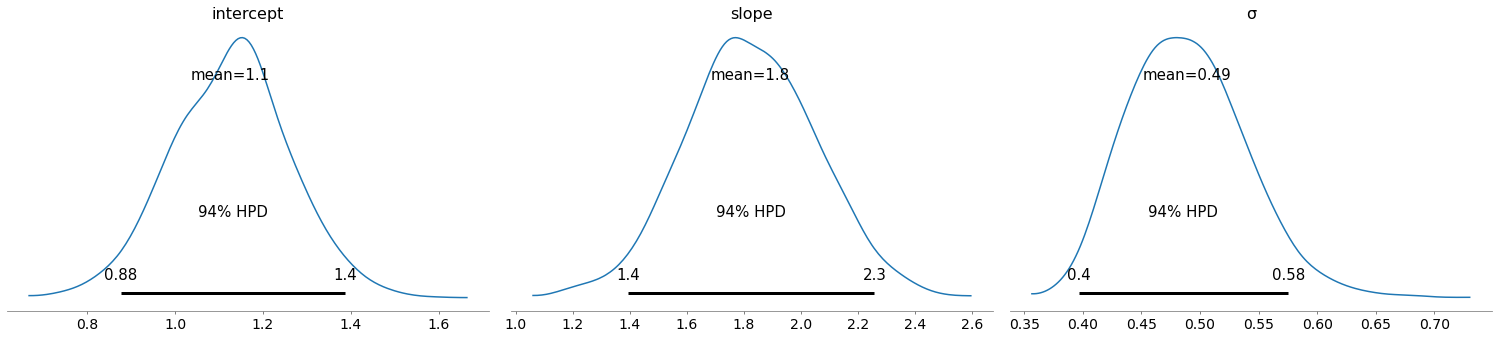

In [9]:
pm.plot_posterior(trace);

<Figure size 432x1008 with 0 Axes>

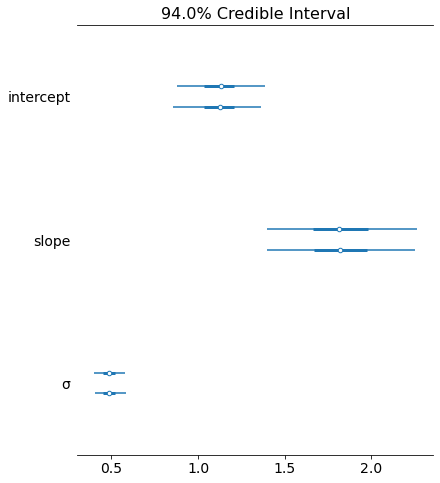

In [10]:
plt.figure(figsize=(6,14))
pm.forestplot(trace, var_names=["intercept", "slope", "σ"]);

The glm.linear_component() function can be used to generate the output variable y_est and coefficients of the specified linear model.

In [11]:
with pm.Model() as model:
    lm = pm.glm.LinearComponent.from_formula("y~x", data)
    σ = pm.HalfCauchy("σ", 1)
    y_obs = pm.Normal("y_obs", mu=lm.y_est, sigma=σ, observed=y)
    trace = pm.sample(draws=2000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, x, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [03:45<00:00, 53.23draws/s]


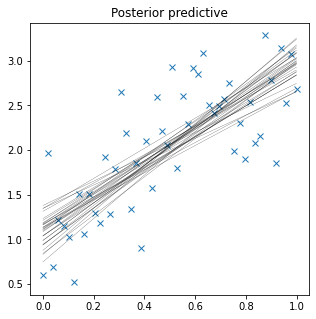

In [12]:
plt.figure(figsize=(5, 5))
plt.plot(x, y, 'x')
pm.plot_posterior_predictive_glm(trace)

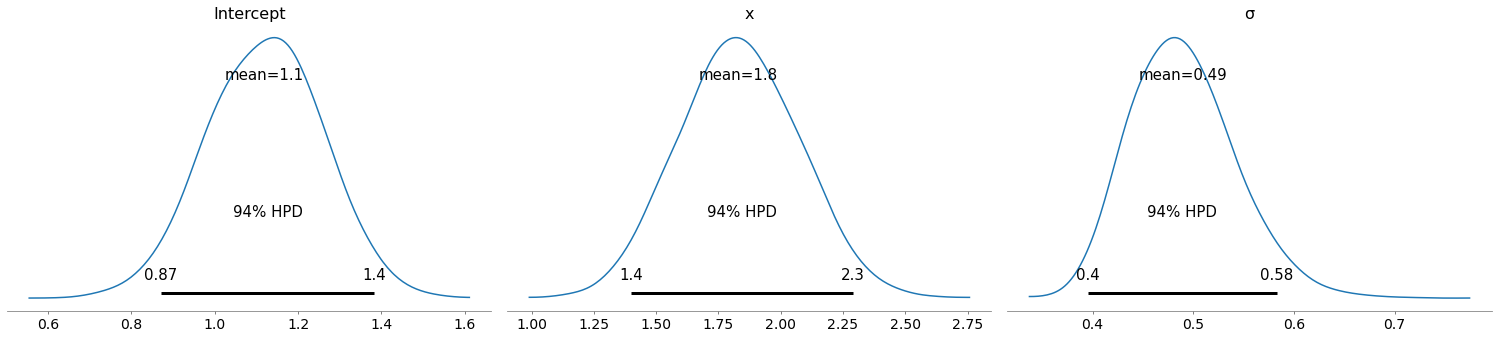

In [13]:
pm.plot_posterior(trace);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [03:45<00:00, 53.20draws/s]
The acceptance probability does not match the target. It is 0.6901170783817474, but should be close to 0.8. Try to increase the number of tuning steps.


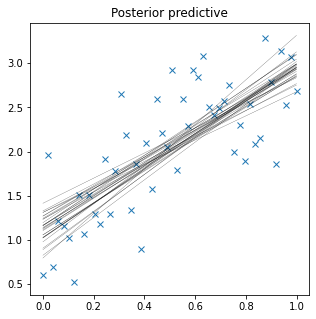

In [14]:
with pm.Model() as model:
    pm.GLM.from_formula('y ~ x', data)
    trace = pm.sample(draws=2000, tune=1000, cores=4)

plt.figure(figsize=(5, 5))
plt.plot(x, y, 'x')
pm.plot_posterior_predictive_glm(trace)

# Robust GLM
Lets try the same model but with a few outliers in the data.

In [15]:
x_out = np.append(x, [.1, .15, .2])
y_out = np.append(y, [8, 6, 9])
data_outlier = dict(x=x_out, y=y_out)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, x, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [04:20<00:00, 19.17draws/s]
The acceptance probability does not match the target. It is 0.890381532459486, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8869177243228027, but should be close to 0.8. Try to increase the number of tuning steps.


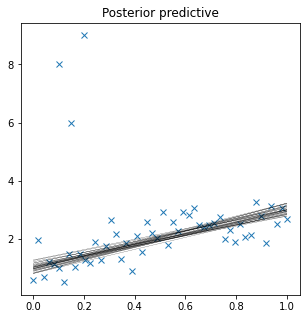

In [16]:
with pm.Model() as model_robust:
    family = pm.glm.families.StudentT(link=pm.glm.families.Identity(),
                                   priors={'nu': 1.5,
                                           'lam': pm.Uniform.dist(0, 20)})
    pm.GLM.from_formula('y ~ x', data_outlier, family=family)
    trace = pm.sample(2000, cores=2)

plt.figure(figsize=(5, 5))
plt.plot(x_out, y_out, 'x')
pm.plot_posterior_predictive_glm(trace)

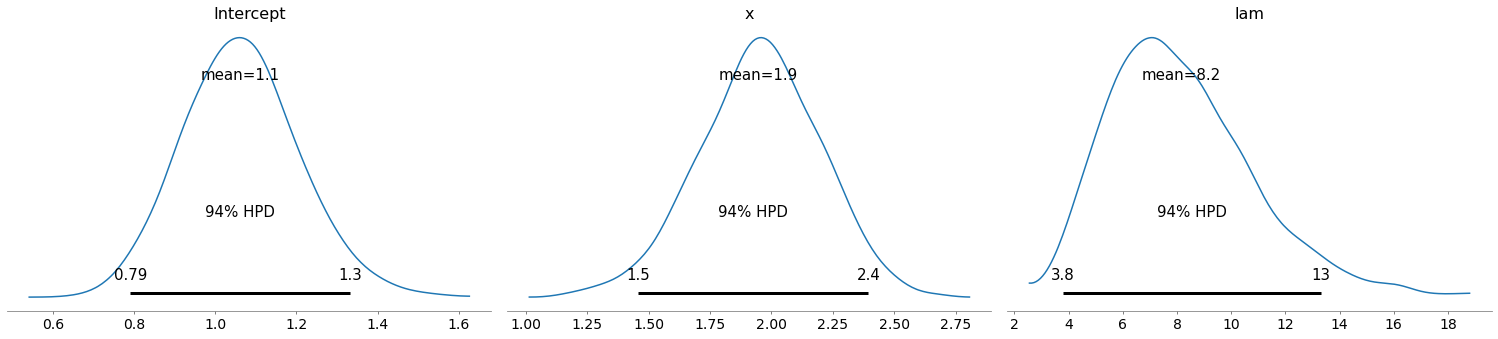

In [17]:
pm.plot_posterior(trace);

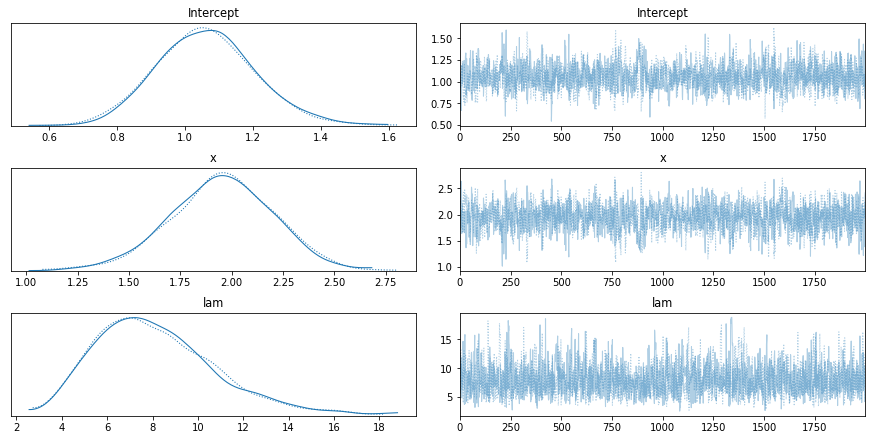

In [18]:
pm.traceplot(trace);

we know in linear regression errors are normally distributed around the centre zero mean, and its standard deviation a positive real number. However, StudentT distribution has a fatter tail, which nice model outlier. Hence, here we are assuming errors are StudentT distributed than Normal

In [19]:
with pm.Model() as model:
    intercept = pm.Normal("intercept", 0, 100)
    slope = pm.Normal("slope", 0, 100)
    lam = pm.Uniform("lam", 0, 20)
    error = y_out - intercept - slope*x_out
    pm.StudentT("error", nu=1.5, lam=lam, observed=error)
    trace = pm.sample(draws=2000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, slope, intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [08:10<00:00, 24.46draws/s]


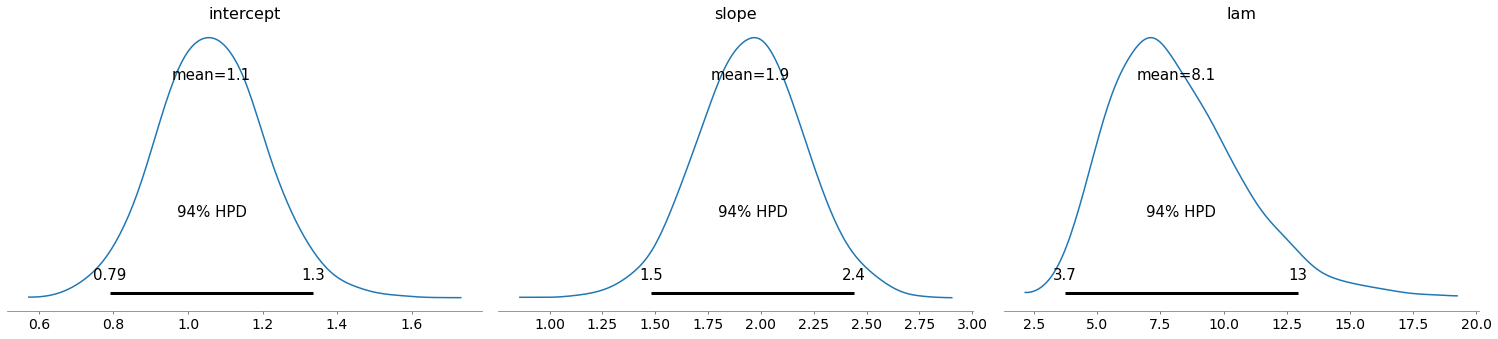

In [20]:
pm.plot_posterior(trace);

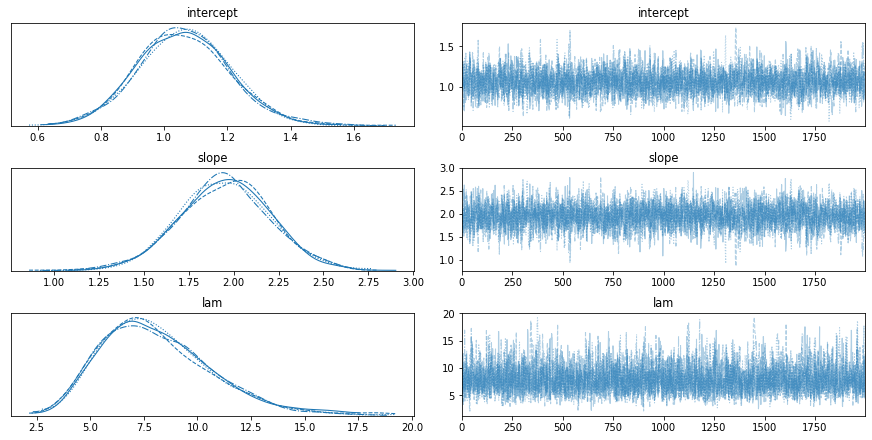

In [21]:
pm.traceplot(trace);

In [22]:
with pm.Model() as model:
    intercept = pm.Normal("intercept", 0, 100)
    slope = pm.Normal("slope", 0, 100)
    lam = pm.Uniform("lam", 0, 20)
    mu = intercept - slope*x_out
    pm.StudentT("y_out", nu=1.5, mu=mu, lam=lam, observed=y_out)
    trace = pm.sample(draws=2000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, slope, intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [04:06<00:00, 48.71draws/s]


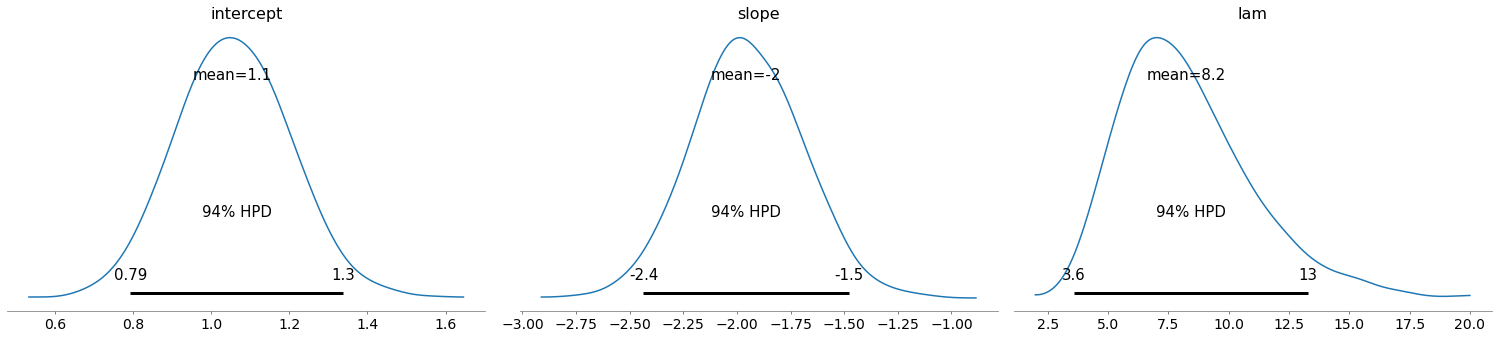

In [23]:
pm.plot_posterior(trace);

In [24]:
with pm.Model() as model:
    intercept = pm.Normal("intercept", 0, 100)
    slope = pm.Normal("slope", 0, 100)
    σ = pm.Uniform("σ", 0, 20)
    mu = intercept - slope*x_out
    pm.Normal("y_out", mu=mu, sigma=σ, observed=y_out)
    trace = pm.sample(draws=2000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, slope, intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [03:36<00:00, 55.37draws/s]
The acceptance probability does not match the target. It is 0.8834387742260645, but should be close to 0.8. Try to increase the number of tuning steps.


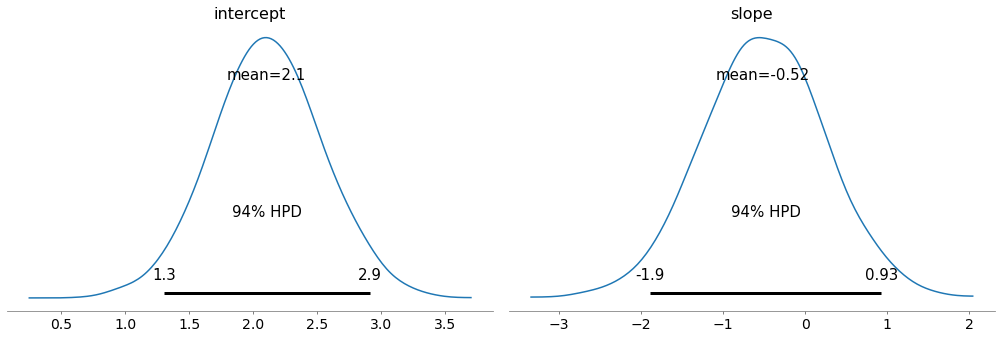

In [25]:
pm.plot_posterior(trace, ["intercept", "slope"]);

In [26]:
pm.backends.tracetab.trace_to_dataframe(trace)

,intercept,slope,σ
0,2.317798,-0.072206,1.643656
1,2.620788,0.308973,1.829214
2,2.351382,-0.812197,1.791556
3,2.325394,-0.696133,1.892908
4,1.951030,-0.996825,1.869016
...,...,...,...
7995,2.758306,0.909761,1.565523
7996,2.734786,0.926176,1.546432
7997,2.962163,1.061094,1.672137
7998,1.477673,-1.565077,1.348123


# Hierarchical GLM

In [19]:
path=r"C:\Users\smrut\git_repo\pymc3\pymc3\examples\data\Guber1999data.txt"
sat_data = pd.read_csv(path)
sat_data.head()

,spend,stu_tea_rat,salary,prcnt_take,sat_v,sat_m,sat_t
Alabama,4.405,17.2,31.144,8,491,538,1029
Alaska,8.963,17.6,47.951,47,445,489,934
Arizona,4.778,19.3,32.175,27,448,496,944
Arkansas,4.459,17.1,28.934,6,482,523,1005
California,4.992,24.0,41.078,45,417,485,902


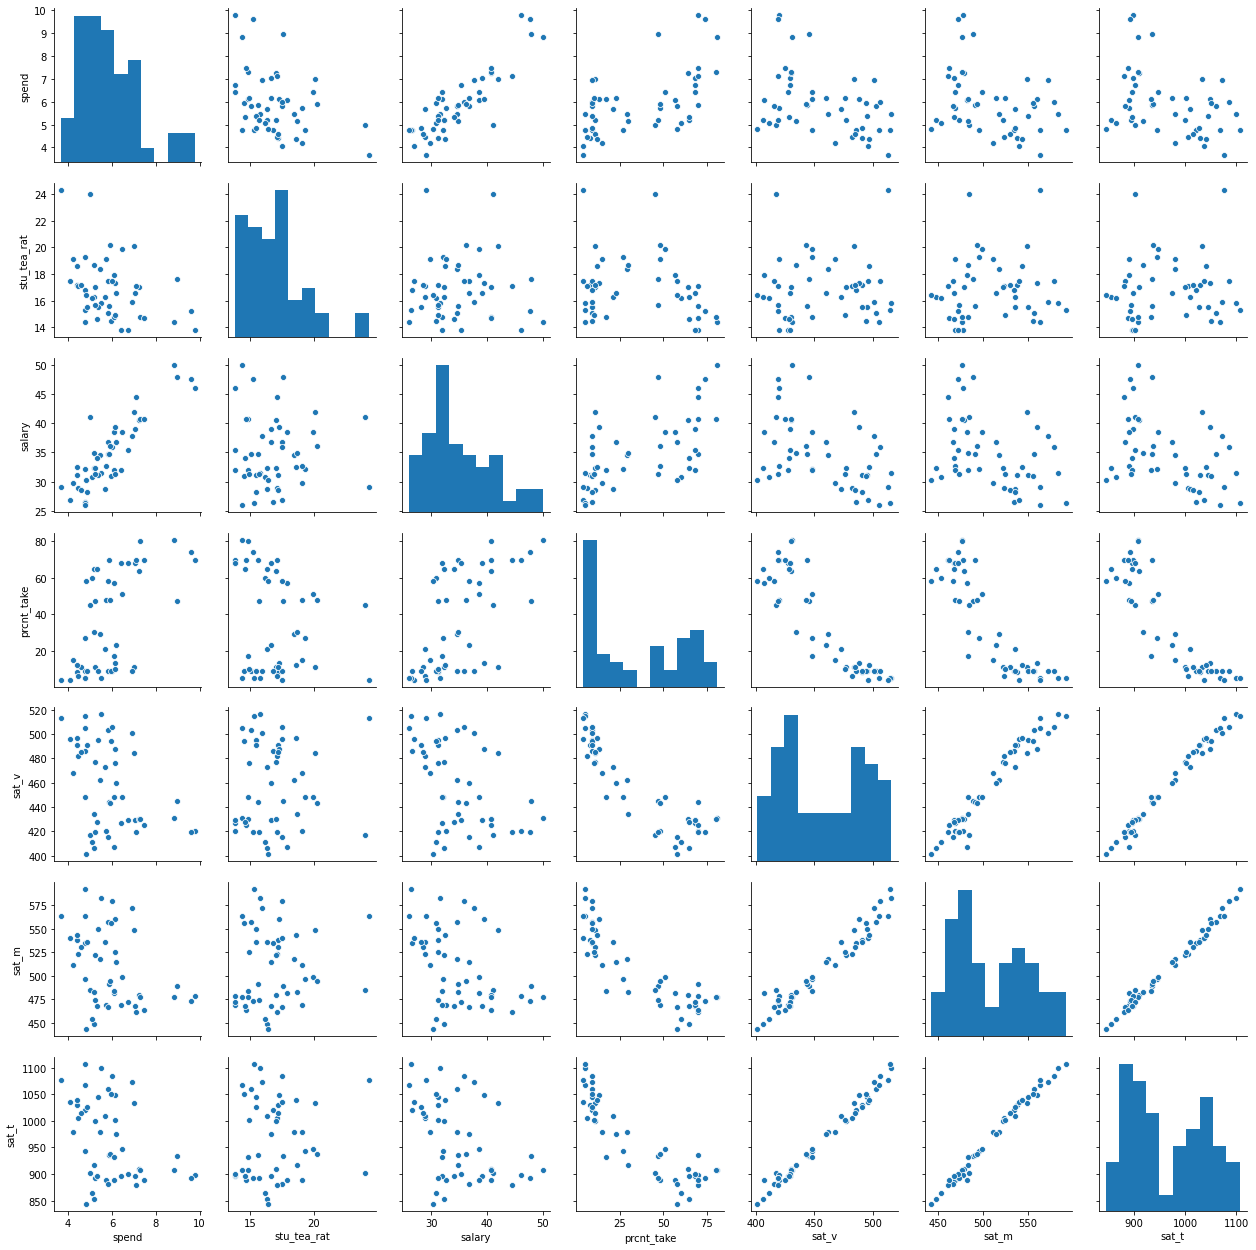

In [37]:
sns.pairplot(sat_data)
plt.show()

In [40]:
with pm.Model() as model_sat:
    grp_mean = pm.Normal('grp_mean', mu=0, sigma=10)
    grp_sd = pm.Uniform('grp_sd', 0, 200)
    # Define priors for intercept and regression coefficients.
    priors = {'Intercept': pm.Normal.dist(mu=sat_data.sat_t.mean(), sigma=sat_data.sat_t.std()),
              'spend': pm.Normal.dist(mu=grp_mean, sigma=grp_sd),
              'stu_tea_rat': pm.Normal.dist(mu=grp_mean, sigma=grp_sd),
              'salary': pm.Normal.dist(mu=grp_mean, sigma=grp_sd),
              'prcnt_take': pm.Normal.dist(mu=grp_mean, sigma=grp_sd)
              }
    pm.GLM.from_formula(
        'sat_t ~ spend + stu_tea_rat + salary + prcnt_take', sat_data, priors=priors)
    trace_sat = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, prcnt_take, salary, stu_tea_rat, spend, Intercept, grp_sd, grp_mean]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [13:23<00:00,  6.23draws/s]
The acceptance probability does not match the target. It is 0.8959993420187605, but should be close to 0.8. Try to increase the number of tuning steps.


C:\Users\smrut\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\smrut\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\smrut\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\smrut\Anaconda3\lib\site-packages\pandas\plotting\_matpl

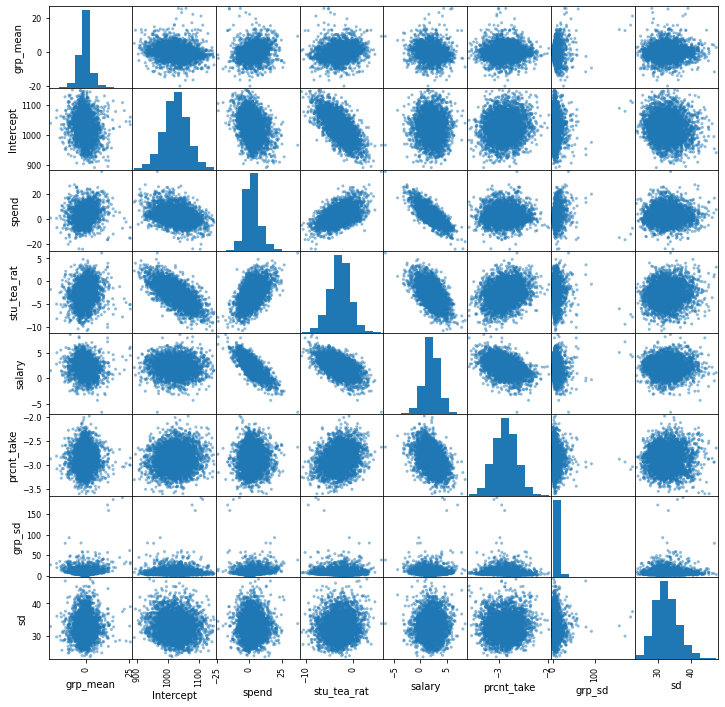

In [48]:
pd.plotting.scatter_matrix(pm.trace_to_dataframe(trace_sat), figsize=(12,12));

# Lasso

In [59]:
with pm.Model():
    priors = {
        'Intercept': pm.Normal.dist(mu=0, sigma=50),
        'Regressor': pm.Laplace.dist(mu=0, b=0.05)
             }
    pm.GLM.from_formula('sat_t ~ spend + stu_tea_rat + salary + prcnt_take', sat_data, priors=priors)
    trace_sat = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, prcnt_take, salary, stu_tea_rat, spend, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [07:56<00:00, 10.50draws/s] 
The acceptance probability does not match the target. It is 0.9287247664634304, but should be close to 0.8. Try to increase the number of tuning steps.


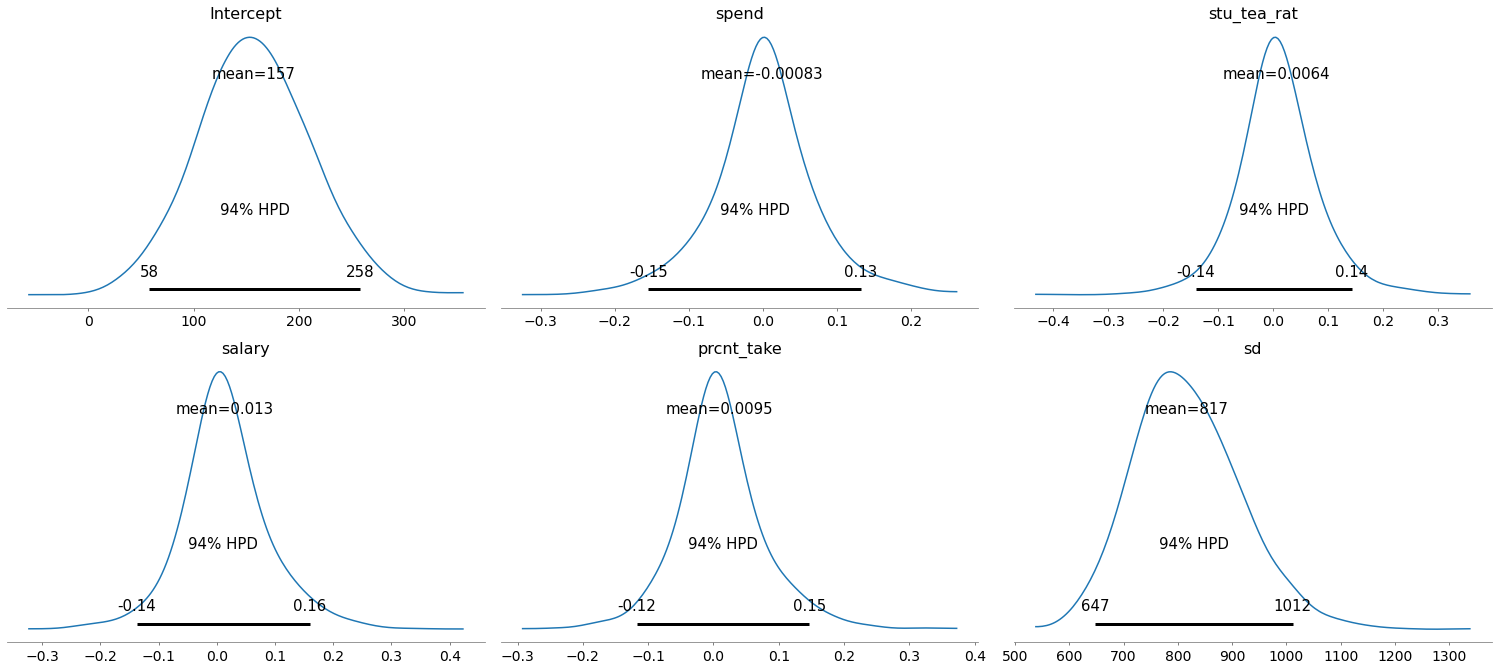

In [61]:
pm.plot_posterior(trace_sat);

In [65]:
print(pm.trace_to_dataframe(trace_sat).describe().drop('count').T)

                   mean        std         min         25%         50%  \
Intercept    156.633036  53.236231  -56.453792  120.347892  155.647544   
spend         -0.000834   0.069627   -0.324621   -0.035760   -0.000373   
stu_tea_rat    0.006392   0.073110   -0.431286   -0.032011    0.002932   
salary         0.012978   0.075168   -0.322581   -0.027374    0.007356   
prcnt_take     0.009525   0.068303   -0.292215   -0.026311    0.004421   
sd           816.810957  98.088390  538.444881  748.657148  809.017689   

                    75%          max  
Intercept    192.628316   356.050327  
spend          0.034769     0.261499  
stu_tea_rat    0.044419     0.357632  
salary         0.050271     0.422735  
prcnt_take     0.040541     0.372212  
sd           878.453731  1338.093084  
